In [2]:
#Importing libraries
import os
import numpy as np

#To dump trained models in the .h5 extension
import h5py

#For Viz
import matplotlib.pyplot as plt

#To train a classification model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

#Categorical cross entropy optimizer
from tensorflow.keras.losses import SparseCategoricalCrossentropy

#Utility functions
from sklearn.metrics import accuracy_score
from sys import getsizeof

In [3]:
print(tf.__version__)

2.9.2


In [4]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [5]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [6]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [9]:
train_images.shape

(60000, 28, 28)

In [10]:
len(train_labels)

60000

In [11]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [12]:
test_images.shape

(10000, 28, 28)

In [13]:
len(test_labels)

10000

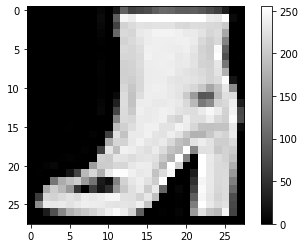

In [14]:
plt.figure()
plt.imshow(train_images[88], cmap="gray")
plt.colorbar()
plt.grid(False)
plt.show()

In [15]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [16]:
model = keras.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10)
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='adam',
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 6s 2ms/step - loss: 0.5029 - accuracy: 0.8238
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3768 - accuracy: 0.8640
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3371 - accuracy: 0.8768
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3154 - accuracy: 0.8839
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2955 - accuracy: 0.8909
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2829 - accuracy: 0.8960
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2688 - accuracy: 0.9000
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2595 - accuracy: 0.9025
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2492 - accuracy: 0.9074
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.239

In [20]:
KERAS_MODEL_NAME = "tf_model_fashion_mnist.h5"

In [21]:
model.save(KERAS_MODEL_NAME)

In [22]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

File size: 1.191 Megabytes


In [23]:
keras_model_size = get_file_size(KERAS_MODEL_NAME)

In [24]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy is {}%'.format(round(100*test_acc, 2)))

313/313 - 1s - loss: 0.3379 - accuracy: 0.8816 - 677ms/epoch - 2ms/step

Test accuracy is 88.16%


In [25]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"

In [26]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

In [27]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

408808

In [28]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

File size: 399.227 Kilobytes


In [29]:
tflite_file_size = get_file_size(TF_LITE_MODEL_FILE_NAME)

In [30]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 28 28]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Type: <class 'numpy.float32'>


In [31]:
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 28, 28))
interpreter.resize_tensor_input(output_details[0]['index'], (10000, 10))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [10000    28    28]
Input Type: <class 'numpy.float32'>
Output Shape: [10000    10]
Output Type: <class 'numpy.float32'>


In [32]:
test_images.dtype

dtype('float64')

In [33]:
test_imgs_numpy = np.array(test_images, dtype=np.float32)

In [34]:
test_imgs_numpy.dtype

dtype('float32')

In [35]:
interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (10000, 10)


In [36]:
acc = accuracy_score(prediction_classes, test_labels)

In [37]:
print('Test accuracy TFLITE model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE model is 88.16%


In [38]:
tflite_file_size/keras_model_size

0.32743618002870617

# TF Lite Model Float 16

In [39]:
TF_LITE_MODEL_FLOAT_16_FILE_NAME = "tf_lite_float_16_model.tflite"

In [40]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_converter.target_spec.supported_types = [tf.float16]
tflite_model = tf_lite_converter.convert()

In [41]:
tflite_model_name = TF_LITE_MODEL_FLOAT_16_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

205872

In [42]:
convert_bytes(get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME), "KB")

File size: 201.047 Kilobytes


In [43]:
tflite_float_16_file_size = get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME)

In [44]:
tflite_float_16_file_size/keras_model_size

0.16489388968628255

In [45]:
tflite_float_16_file_size/tflite_file_size

0.5035909277704937

# TF Lite Size Quantized

In [46]:
TF_LITE_SIZE_QUANT_MODEL_FILE_NAME = "tf_lite_quant_model.tflite"

In [47]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = tf_lite_converter.convert()

In [48]:
tflite_model_name = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

104040

In [49]:
convert_bytes(get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME), "KB")

File size: 101.602 Kilobytes


In [50]:
tflite_float_quant_file_size = get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)

In [51]:
tflite_float_quant_file_size/keras_model_size

0.08333119745745335

In [52]:
tflite_float_quant_file_size/ tflite_float_16_file_size

0.5053625553742132

# Accuracy of the Quantized Model

# Check Input Tensor Shape

In [53]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 28 28]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Type: <class 'numpy.float32'>


# Resize Tensor Shape

In [54]:
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 28, 28))
interpreter.resize_tensor_input(output_details[0]['index'], (10000, 10))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [10000    28    28]
Input Type: <class 'numpy.float32'>
Output Shape: [10000    10]
Output Type: <class 'numpy.float32'>


In [55]:
test_images.dtype

dtype('float64')

In [56]:
test_imgs_numpy = np.array(test_images, dtype=np.float32)

In [57]:
interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (10000, 10)


In [58]:
acc = accuracy_score(prediction_classes, test_labels)

In [59]:
print('Test accuracy TFLITE Quantized model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE Quantized model is 88.2%
